# under construction


In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pyrtools as ppt
%load_ext autoreload
%autoreload 2

In [2]:
# Spatial domain steerability

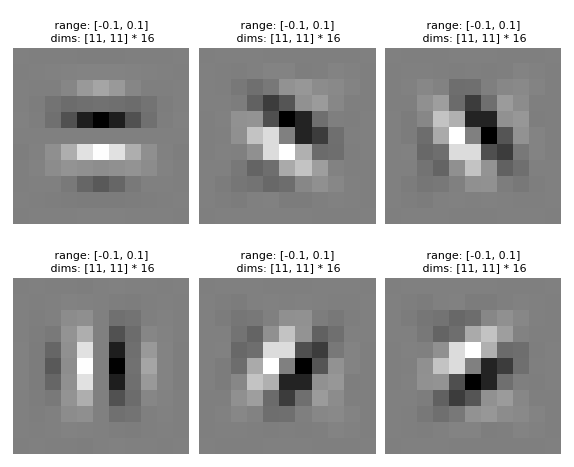

In [3]:
# Choose a filter set (options are 'sp0Filters', 'sp1Filters', 'sp3Filters', 'sp5Filters'):
filters = ppt.steerable_filters('sp5Filters')
fsz = int(np.round(np.sqrt(filters['bfilts'].shape[0])))

fsz = np.array([fsz, fsz])
nfilts = filters['bfilts'].shape[1]
nrows = int(np.floor(np.sqrt(nfilts)))

import scipy.signal as sps
# Look at the oriented bandpass filters:
filtList = []
for f in range(nfilts):
    filtList.append(sps.convolve2d(filters['bfilts'][:,f].reshape(fsz), filters['lo0filt']))

ppt.showIm(filtList, zoom= 16, col_wrap= 3);

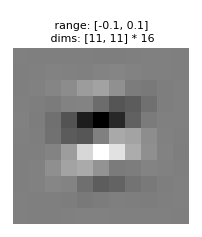

In [4]:
# Try "steering" to a new orientation (new_ori in degrees):
new_ori = -12

ppt.showIm( sps.convolve2d( ppt.steer(filters['bfilts'],
                                      new_ori * np.pi/180).reshape(fsz),
                           filters['lo0filt']), 'auto', 16);

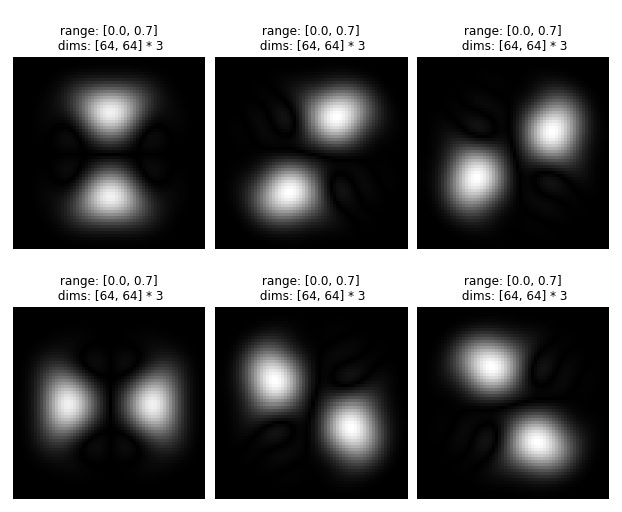

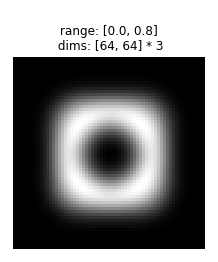

In [5]:
# Look at Fourier transform magnitudes:
lo0filt = filters['lo0filt']
bfilts = filters['bfilts']
lo0 = np.fft.fftshift(np.abs(np.fft.fft2(filters['lo0filt'],(64,64))))
fsum = np.zeros(lo0.shape)
imgList = []
for f in range(bfilts.shape[1]):
    flt = bfilts[:,f].reshape(fsz)
    freq = lo0 * np.fft.fftshift(np.abs(np.fft.fft2(flt,(64,64))))
    fsum += freq**2
    imgList.append(freq)

ppt.showIm(imgList, vrange='auto', zoom=3, col_wrap= 3)

# The filters sum to a smooth annular ring:
ppt.showIm(fsum, 'auto', 3);

In [6]:
# Steering the activations of a pyramid

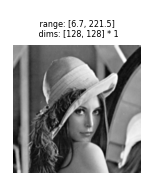

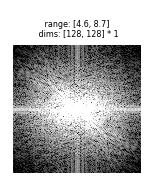

In [7]:
im = plt.imread('../pyrtools/data/lenna-256x256.tif').astype(float)

binom5 = ppt.binomialFilter(5)
lo_filt = binom5*binom5.T
im = ppt.corrDn(im, np.flipud(np.fliplr(lo_filt)), 'reflect1', step=[2, 2])

imgSize = im.shape[0]

ppt.showIm(im);
ppt.showIm(np.log(np.fft.fftshift(np.abs(np.fft.fft2(im, s=(imgSize, imgSize))))), vrange='auto3');

In [8]:
nOri = 3
pyr = ppt.SFpyr(im, height=1, order=nOri - 1)

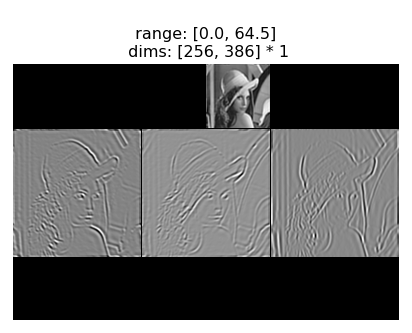

In [9]:
pyr.showPyr('indep1')

In [10]:
# making a basis out of the 
b = [pyr.pyr[i] for i in range(1, nOri + 1)]
B = np.vstack([b[i].flatten() for i in range(nOri)]).T

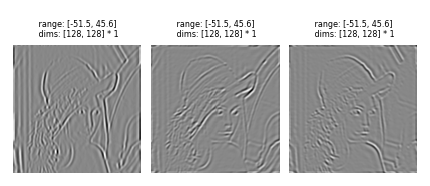

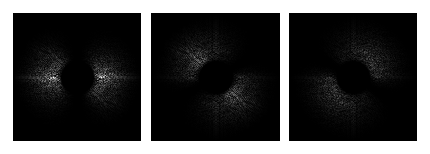

In [11]:
ppt.showIm([b[i] for i in range(nOri)], col_wrap=3);

fmag = []
for i in range(nOri):
    freq = np.fft.fftshift(np.abs(np.fft.fft2(b[i], s=(imgSize, imgSize))))
    fmag.append(freq)

ppt.showIm(fmag, col_wrap=3, title=None);

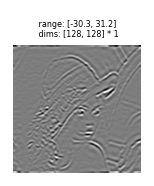

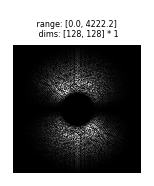

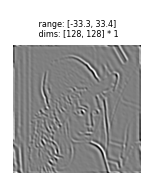

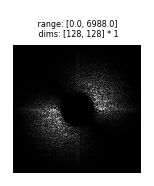

In [12]:
b0 = ppt.steer(B, angle = np.pi / 2)
b1 = ppt.steer(B, angle = - np.pi / 4)

b0 = b0.reshape((imgSize,imgSize))
b1 = b1.reshape((imgSize,imgSize))

ppt.showIm(b0);
ppt.showIm(np.fft.fftshift(np.abs(np.fft.fft2(b0, s=(imgSize, imgSize)))));

ppt.showIm(b1);
ppt.showIm(np.fft.fftshift(np.abs(np.fft.fft2(b1, s=(imgSize, imgSize)))));

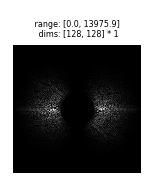

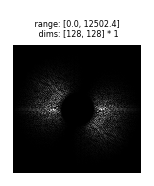

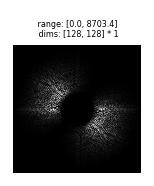

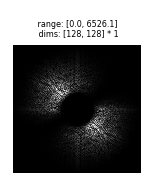

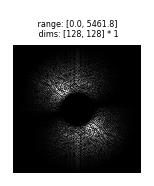

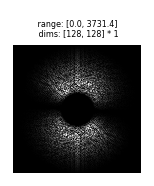

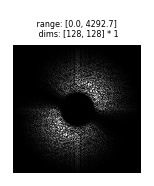

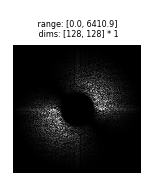

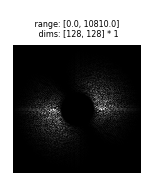

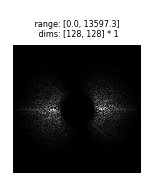

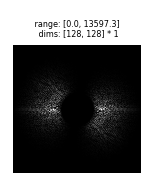

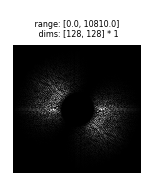

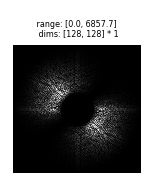

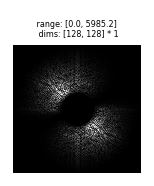

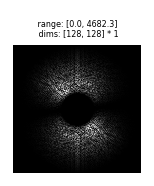

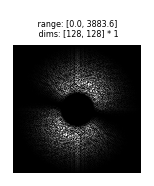

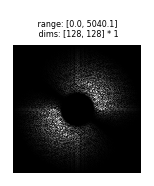

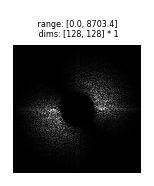

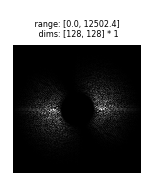

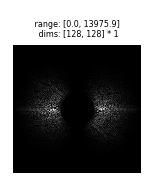

In [13]:
steeredim = []
for i in np.linspace(-180, 180, 20):
    bi = ppt.steer(B, angle = i * np.pi / 180)
    bi = bi.reshape((imgSize,imgSize))
    steeredim.append(bi)
    ppt.showIm(np.fft.fftshift(np.abs(np.fft.fft2((bi), s=(imgSize, imgSize)))))

In [14]:
# TODO
# track down error in the odd case
# even_phase = False
# TODO
# compare to:
# matlab code
# and pytorch code

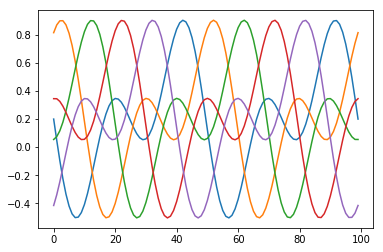

In [15]:
nOri = 5
even_phase = False

pyr = ppt.SFpyr(im, height=1, order=nOri - 1)

b = [pyr.pyr[i] for i in range(1, nOri + 1)]
B = np.vstack([b[i].flatten() for i in range(nOri)]).T

steervect = []
steeredim = []
for i in np.linspace(-180, 180, 100):
    bi, vi = ppt.steer(B, angle = i * np.pi / 180, return_weights=True, even_phase=even_phase)
    steervect.append(vi)
    bi = bi.reshape((imgSize,imgSize))
    steeredim.append(bi)
    
plt.figure()
for i in range(nOri):
    plt.plot(np.array(steervect)[:,i])
plt.show()

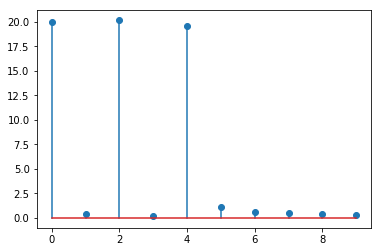

In [16]:
# sampling error
i = np.random.choice(nOri)
sp = np.fft.fftshift(np.fft.fft(np.array(steervect)[:,i]))
plt.stem(np.abs(sp)[sp.shape[0] // 2 : sp.shape[0] // 2 + nOri * 2])
plt.show()

In [17]:
import matplotlib.animation
from IPython.display import display, clear_output
import time

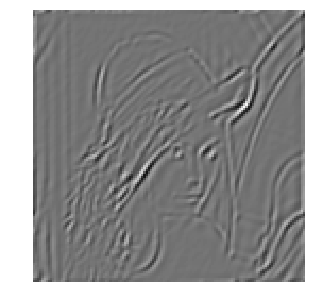

In [18]:
fig, ax = plt.subplots(figsize = (5,5))
a = ax.imshow(np.eye(256), cmap='gray', interpolation='none', vmin=np.min(steeredim), vmax=np.max(steeredim))
ax.axis('off')

animate = lambda i: a.set_data(steeredim[i])

for i in range(len(steeredim)):
    animate(i)
    clear_output(wait=True)
    display(fig)
    time.sleep(.01)

clear_output()
plt.show()

In [19]:
# TODO
# use ppt.showIm inside animation?
# display using animation.FuncAnimation and HTML(anim.to_html5_video())
# saving using anim.save('basic_animation.mp4', fps=30, extra_args=['-vcodec', 'libx264']) 

In [20]:
# from matplotlib import animation

# fig, ax = plt.subplots(figsize = (5,5))
# a = ax.imshow(steeredim[0],
#               cmap='gray', interpolation='none', vmin=np.min(steeredim), vmax=np.max(steeredim))
# ax.axis('off')

# # initialization function: plot the background of each frame
# def init():
#     a.set_data(steeredim[0])
#     return [a]

# # animation function.  This is called sequentially
# def animate(i):
#     a.set_data(steeredim[i])
#     return [a]

# # call the animator.  blit=True means only re-draw the parts that have changed.
# anim = animation.FuncAnimation(fig, animate, init_func=init,
#                                frames=len(steeredim), interval=200, blit=True)

# conda install -c conda-forge ffmpeg
# conda install matplotlib

# from IPython.display import HTML
# # HTML(anim.to_html5_video())
# HTML(anim.to_jshtml())

# from matplotlib import rcParams

# rcParams['animation.html'] = 'html5'

# anim

# print(animation.writers.list())


# ani.save('animation.mp4', writer='ffmpeg', codec='rawvideo')
# jupyter notebook --NotebookApp.iopub_data_rate_limit=10000000000
# https://github.com/VolkerH/interpolation_and_aliasing_matplotlib/blob/master/Interpolation%2Band%2BAliasing.ipynb

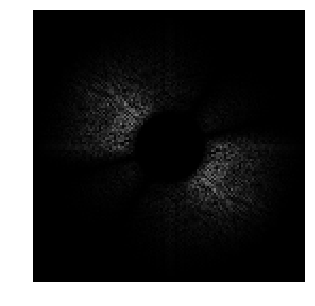

In [21]:
steeredim_dftampl = []
for i in range(len(steeredim)):
    steeredim_dftampl.append(np.fft.fftshift(np.abs(np.fft.fft2((steeredim[i]),s=(imgSize, imgSize)))))

fig, ax = plt.subplots(figsize = (5,5))
l = ax.imshow(np.eye(256), cmap='gray', interpolation='none', vmin=np.min(steeredim_dftampl), vmax=np.max(steeredim_dftampl))
ax.axis('off')

animate = lambda i: l.set_data(steeredim_dftampl[i])

for i in range(len(steeredim)):
    animate(i)
    clear_output(wait=True)
    display(fig)
    time.sleep(.01)

clear_output()
plt.show()

In [22]:
# np.fft.fftshift(np.abs(np.fft.fft2((steeredim[i]),s=(imgSize, imgSize)))).max()

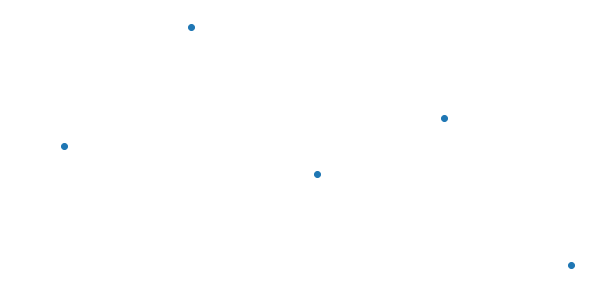

In [23]:
fig, ax = plt.subplots(figsize = (10,5))
ax.axis('off')
ax.set_ylim((np.min(steervect), np.max(steervect)))

a, = ax.plot(np.arange(nOri), steervect[0], 'o')

animate = lambda i: a.set_data((np.arange(nOri), steervect[i]))

for i in range(len(steervect)):
    animate(i)
    clear_output(wait=True)
    display(fig)
    time.sleep(.01)

clear_output()
plt.show()

In [24]:
# https://matplotlib.org/examples/animation/rain.html
# https://jakevdp.github.io/blog/2012/08/18/matplotlib-animation-tutorial/